# Lab 02-2

Model evaluation, testing, and calibration

<div class="alert alert-warning">
If equations or tables are not displayed properly, please go to the top menu and select View - Activate Command Palette, then search for and execute the "Trust Notebook" command.
</div>

<div class="alert alert-info">
Some parts of the code are left empty like #= .. =#, please fill in those parts during the practice session.
</div>

In [1]:
using Cropbox

## 1. Calibration 

In this exercise, we will calibrate the logistic and Gompertz growth functions using experimental data from field corn research.

1. Calibrate the integral form of the logistic equation against the corn total shoot biomass data collected over time. What are your starting values for the parameters?
2. Do the same with the integral form of the Gompertz equation. What are your starting values for the parameters?
3. Evaluate the performance of the two models and determine which model fits data better. Use appropriate statistics as needed. Which model was easier with more interpretable parameters for you to determine their starting values?
4. Plot predicted vs observed values for both models and compare
5. Choose a function and use is to calibrate the biomass of each part (e.g., leaf, stem, and ear)

## 1.1. Dataset

We can load CSV files into a table-like structure (`DataFrame`) using [CSV.jl](https://github.com/JuliaData/CSV.jl) package.

Cropbox additionally provides a convenience feature with `unitfy()` function that automatically handle units for each column. For example, if the column name was set to "LA (cm^2)" in the CSV file, it would be converted to a column named "LA" and its underlying type incorprating units of "cm^2".

Note that we used piping operator (`|>`) to hand over the data frame returned by `CSV.read()` to `unitfy()` function. It's identical as if we called `unitfy(CSV.read(...))`.

In [2]:
using DataFrames
using CSV

In [3]:
corn = CSV.read("corn_sample.csv", DataFrame) |> unitfy

Row,year,jday,day,SampleNo,Stage,Ht,Diameter,TotLfNo,LA,StemDW,LfDW,EarDW,Green,LfNo,DAS,shootDW,SLA
,Int64,Int64,Date,Int64,String3?,Float64?,Quantity…?,Int64?,Quantity…,Quantity…,Quantity…,Quantity…,Int64?,Int64?,Quantity…,Quantity…,Quantity…
1,2002,162,2002-06-11,1,V5,48.0,missing,7,178.57 cm^2,0.675 g,0.829 g,0.0 g,missing,7,27 d,1.504 g,215.404 cm^2 g^-1
2,2002,162,2002-06-11,2,V5,44.0,missing,8,220.09 cm^2,0.9 g,1.007 g,0.0 g,missing,8,27 d,1.907 g,218.56 cm^2 g^-1
3,2002,162,2002-06-11,3,V5,40.0,missing,7,152.73 cm^2,0.455 g,0.611 g,0.0 g,missing,7,27 d,1.066 g,249.967 cm^2 g^-1
4,2002,162,2002-06-11,4,V5,49.5,missing,8,306.52 cm^2,1.32 g,1.389 g,0.0 g,missing,8,27 d,2.709 g,220.677 cm^2 g^-1
5,2002,162,2002-06-11,5,V5,51.5,missing,9,276.78 cm^2,1.056 g,1.269 g,0.0 g,missing,9,27 d,2.325 g,218.109 cm^2 g^-1
6,2002,162,2002-06-11,6,V5,48.5,missing,8,198.26 cm^2,0.81 g,0.892 g,0.0 g,missing,8,27 d,1.702 g,222.265 cm^2 g^-1
7,2002,162,2002-06-11,7,V5,49.0,missing,8,207.5 cm^2,0.901 g,1.016 g,0.0 g,missing,8,27 d,1.917 g,204.232 cm^2 g^-1
8,2002,162,2002-06-11,8,V5,40.5,missing,7,135.7 cm^2,0.568 g,0.622 g,0.0 g,missing,7,27 d,1.19 g,218.167 cm^2 g^-1
9,2002,162,2002-06-11,9,V4,39.0,missing,7,123.88 cm^2,0.392 g,0.545 g,0.0 g,missing,7,27 d,0.937 g,227.303 cm^2 g^-1


There are many columns in the data frame as we can see with `names()` function.

In [4]:
names(corn)

17-element Vector{String}:
 "year"
 "jday"
 "day"
 "SampleNo"
 "Stage"
 "Ht"
 "Diameter"
 "TotLfNo"
 "LA"
 "StemDW"
 "LfDW"
 "EarDW"
 "Green"
 "LfNo"
 "DAS"
 "shootDW"
 "SLA"

`DAS` means "days after sowing". We have dry weights (DW) for shoot (`shootDW`), stem (`StemDW`), leaf (`LfDW`), and ear (`EarDW`).

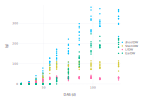

In [5]:
visualize(corn, :DAS, [:shootDW, :StemDW, :LfDW, :EarDW])

Among them, we'll first use shoot dry weight (`shootDW`) to calibrate the logistic growth model we learned last week.

### 1.2. Logistic Equation

#### 1.2.1. Model Specification

- Eq

$$
\frac{dW}{dt} = r W \left( 1 - \frac{W}{W_f} \right)
$$

- Table

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{d}$ | Time unit used in the model |
| $r$ | - | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Relative (or specific or intrinsic) growth rate |
| $W_0$ | - | $\mathrm{g}$ | Seed mass or initial biomass |
| $W_f$ | - | $\mathrm{g}$ | Potential final mass of a plant |
| $W$ | - | $\mathrm{g}$ | Whole-plant biomass as dry matter (state variable) |

Here is the logistic growth model we're going to use for modeling biomass accumulation. It's basically the same as the system `Logi` we created in the past lab, but now the system takes advantage of explicit units attached to the variables.

In [6]:
@system Logistic(Controller) begin
    t(context.clock.time) ~ track(u"d")

    r:  relative_growth_rate    ~ preserve(parameter, u"g/g/d")
    W0: initial_biomass         ~ preserve(parameter, u"g")
    Wf: potential_final_biomass ~ preserve(parameter, #= .. =#)

    W(#= .. =#): biomass => begin
        #= .. =#
    end ~ accumulate(init = #= .. =#, u"g")
end

Logistic

Cropbox provides `calibrate()` function to find out a set of parameters best describing the dataset it's provided with. Internally, it relies on [BlackBoxOptim.jl](https://github.com/robertfeldt/BlackBoxOptim.jl) for global optimization methods. If you're interested in local optimization methods, refer to [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package for more information.

`calibrate()` is in a form like `calibrate(<System>, <DataFrame>; index=<..>, target=<..>, parameters=<..>, metric=<..>, optim=(; <BlackBoxOptim options>..), <simulate() options>..`. It acceps arguments similar to `simulate()` for setting up simulations. Then it also requires a data frame for ground truth data and their column names for `index` and `target` variables. Oftentimes, it is in a time series like how our dataset is recorded for corn harvest measurements. `parameters` are in a format similar to Cropbox configuration object except that each variable has a tuple of values specifying lower and upper bounds of the parameter instead of an actual value.

In this case, we're calibrating three parameters, `r`, `W0`, and `Wf`, within a reasonable range of values. We use same period of simulation, 150 days, as `stop` condition. The deafult metric of cost (error) function used by calibration is [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation). More advanced options controlling BlackBoxOptim can be specified with optional `optim` including maximum steps of calibration which mainly determines how long calibration process can take.

#### 1.2.2. Calibration

In [7]:
lc = calibrate(Logistic, corn;
    index = :DAS => :t,
    target = :shootDW => :W,
    parameters = Logistic => (;
        r = (0, 1),
        W0 = (0, 10),
        Wf = (0, 500),
    ),
    stop = 150u"d",
    metric = :rmse,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 5.18 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 965.08
Function evals per second = 980.90
Improvements/step = 0.21980
Total function evaluations = 5083


Best candidate found: [0.0727128, 1.84335, 334.293]

Fitness: 30.600511250



r,=,0.0727128 d^-1
W0,=,1.84335 g
Wf,=,334.293 g


After calibration, we found a set of parameter that can describe the observation reasonable well with fitness value of 30.60 which referrs to RMSE. In other words, our simulation with this particular set of parameters had an average error about 30 $\mathrm{g}$ compared to the original dataset.

The result of calibration is returned as a configuration object which can be directly plugged into `simluate()` or `visualize()`. Let's plot the result of simulation using the calibrated parameter set and compare it with the dataset used for calibration.

#### 1.2.3. Simulation & Visualization

Here is the syntax visualize(<DataFrame>, <System>, <x>, <y>; <simulate() options>.., <plot() options>..).

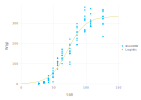

In [9]:
visualize(corn, Logistic, :DAS => :t, :shootDW => :W; config  = lc, stop = 150u"d", xlim = (0, 150))

Another form of `visualize(<DataFrame>, <System>, <y>; index=<..>, <simulate() options>.., <plot() options>..)` provides an 1:1 plot with observation against model estimation.

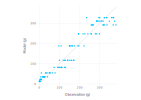

In [10]:
visualize(corn, Logistic, :shootDW => :W; index = :DAS => :t, config = lc, stop = 150u"d")

#### 1.2.4. Alternative Calibration

Let's say we want to force $W_0$ to be 0.275 $\mathrm{g}$ based on our prior knowledge of the seed mass of corn kernels. This will help us reduce the number of parameters to calibrate. This might sacrifice the fitness (e.g., RMSE), but that should be okay. We achieve this by setting `W0` value in a configuration.

In [11]:
lc0 = @config Logistic => :W0 => 0.275

W0,=,0.275 g


In [12]:
lc1 = calibrate(Logistic, corn;
    index = :DAS => :t,
    target = :shootDW => :W,
    config = lc0,
    parameters = Logistic => (;
        r = (0, 1),
        Wf = (0, 500),
    ),
    stop = 150u"d",
    metric = :rmse,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 5.28 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 946.46
Function evals per second = 972.39
Improvements/step = 0.30360
Total function evaluations = 5138


Best candidate found: [0.101706, 312.53]

Fitness: 34.150578210



r,=,0.101706 d^-1
Wf,=,312.53 g


Then we merge the calibrated configuration with the initial configuration we created.

In [13]:
lc2 = @config lc0 + lc1

W0,=,0.275 g
r,=,0.101706 d^-1
Wf,=,312.53 g


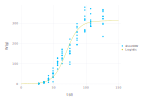

In [14]:
visualize(corn, Logistic, :DAS => :t, :shootDW => :W; config  = lc2, stop = 150u"d", xlim = (0, 150))

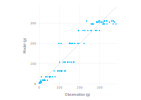

In [15]:
visualize(corn, Logistic, :shootDW => :W; index = :DAS => :t, config = lc2, stop = 150u"d")

## 2. Evaluation

Cropbox provides `evaluate()` function, which is in a similart form to `calibrate()`, for calculating a measure of error between observation input and simulation output. We can specify an arbitrary metric function in `metric` option that accepts a list of estimated values (`E`) and corresponding observed values (`O`) and returns a meausre of error.

### 2.1. Root Mean Square Error (RMSE)

- Eq

$$
\mathrm{RMSE} = \sqrt{\frac{\sum_{i=1}^N (\hat{y}_i - y_i)^2}{N}}
$$

RMSE can be defined by a simple function like this.

In [21]:
using StatsBase

In [22]:
rmse(E, O) = √mean((E .- O).^2)

rmse (generic function with 1 method)

Then call `evaluate()` with our `rmse()` function to calculate RMSE from our simulation.

In [23]:
evaluate(Logistic, corn;
    config = lc,
    index = :DAS => :t,
    target = :shootDW => :W,
    stop = 150u"d",
    metric = rmse,
)

30.60051124968476 g

Actually, Cropbox already has an implementation of commonly used metric functions including RMSE and EF. They are specified by pre-defined symbols (*i.e.* `:rmse` for RMSE, `:ef` for EF).

In [24]:
evaluate(Logistic, corn;
    config = lc,
    index = :DAS => :t,
    target = :shootDW => :W,
    stop = 150u"d",
    metric = :rmse,
)

30.60051124968476 g

Note that RMSE shares the same units (`g`) with the `target` variable which is shoot biomass (`shootDW` column in the dataset mapped to the variable `W` of the model) in this example.

Also beware that what we just did above was not a proper **validation** of calibrated model since the dataset we used for calibration was used again for calculating a measure of error. In other words, we were just looking at the fitness of calibration itself. For validation, we need another dataset independent of calibration.

### 2.2. Model Efficiency (EF)

- Eq

$$
\mathrm{EF} = 1 - \frac{\sum_i (\hat{y}_i - y_i)^2}{\sum_i (y_i - \bar{y})^2}
$$

Model efficiency (EF), or more specficially, Nash-Sutcliffe model efficiency coefficient (NSE) can be defined in a similar way.

In [26]:
ef(E, O) = 1 - sum((E .- O).^2) / sum((O .- mean(O)).^2)

ef (generic function with 1 method)

In [27]:
evaluate(Logistic, corn;
    config = lc2,
    index = :DAS => :t,
    target = :shootDW => :W,
    stop = 150u"d",
    metric = :ef,
)

0.9231185687820941

The maximum value of EF is 1 which indicates a perfect model. When EF is zero, the model has the same predictive power as mean of observations. A negative value of EF indicates the model is worse than the observation mean.

### 2.3 Practice

Let's apply the same calibration process to leaf (`LfDW`).

In [33]:
lc_leaf = calibrate(Logistic, corn;
    index = :DAS => :t,
    target = #= .. =# => :W,
    parameters = Logistic => (;
        #= .. =#
    ),
    stop = 150u"d",
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 5.18 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 965.09
Function evals per second = 986.70
Improvements/step = 0.22500
Total function evaluations = 5113


Best candidate found: [0.20017, 0.00304478, 30.106]

Fitness: 4.144808200



r,=,0.20017 d^-1
W0,=,0.00304478 g
Wf,=,30.106 g


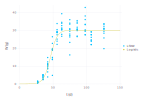

In [34]:
visualize(corn, Logistic, #= .. =#, #= .. =#; config = #= .. =#, stop = 150u"d", xlim = (0, 150))

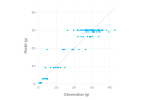

In [35]:
visualize(corn, Logistic, :LfDW => :W; index = :DAS => :t, config = lc_leaf, stop = 150u"d")

In [36]:
evaluate(#= .. =#, #= .. =#;
    config = #= .. =#,
    index = :DAS => :t,
    target = :LfDW => :W,
    stop = 150u"d",
    metric = :rmse,
)

4.144808199875802 g